In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(rf'C:\Users\Romain\Desktop\Trade\Codes\Databases Training\FX\EURUSD_D1.csv')
data.columns = ['date', 'open', 'high', 'low', 'close']
data['date'] = pd.to_datetime(data['date'], format="%d-%m-%Y")
data['ohlc4'] = (data['open'] + data['high'] + data['low'] + data['close']) / 4 
#data = data[data['date'].dt.year >= 2021]
data = data.set_index(['date'])

ma_short_period = 10
ma_long_period = 70

data["buy_signal"] = False
data["sell_signal"] = False

data["ma_short"] = data["close"].rolling(ma_short_period).mean()
data["ma_long"] = data["close"].rolling(ma_long_period).mean()

data["crossover"] =  data["ma_short"] - data["ma_long"]
data.loc[(data["crossover"] > 0) & (data["crossover"].shift(1) <= 0), "buy_signal"] = True
data.loc[(data["crossover"] < 0) & (data["crossover"].shift(1) >= 0), "sell_signal"] = True
data = data.dropna()
data["sell_signal"].value_counts()

sell_signal
False    4890
True       54
Name: count, dtype: int64

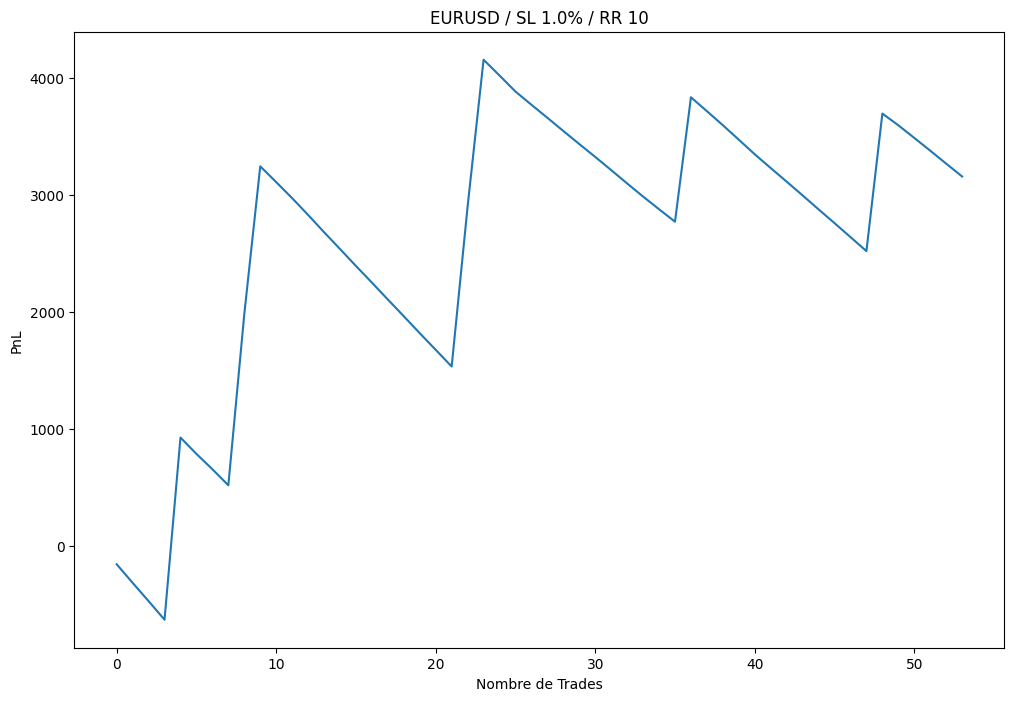

In [142]:
in_pos = None
stop_loss = 0.01
rr = 10
lots = 0.1
spread = 0.0001
strat_logs = []

for index, row in data.iterrows():
    if in_pos == 'long':
        if row.low <= actual_stop:
            # Stop loss atteint
            exit_price = actual_stop
            exit_time = index
            pnl = exit_price - entry_price
            strat_logs.append([exit_price, entry_price, in_pos, entry_time, exit_time, pnl])
            in_pos = None
        elif row.high >= take_profit:
            # Take profit atteint
            exit_price = take_profit
            exit_time = index
            pnl = exit_price - entry_price
            strat_logs.append([exit_price, entry_price, in_pos, entry_time, exit_time, pnl])
            in_pos = None
    elif in_pos == 'short':
        if row.high >= actual_stop:
            # Stop loss atteint
            exit_price = actual_stop
            exit_time = index
            pnl = entry_price - exit_price
            strat_logs.append([exit_price, entry_price, in_pos, entry_time, exit_time, pnl])
            in_pos = None
        elif row.low <= take_profit:
            # Take profit atteint
            exit_price = take_profit
            exit_time = index
            pnl = entry_price - exit_price
            strat_logs.append([exit_price, entry_price, in_pos, entry_time, exit_time, pnl])
            in_pos = None
    else:
        # Pas en position
        if row["buy_signal"]:
            # Entrée en position longue
            in_pos = 'long'
            entry_price = row.ohlc4
            actual_stop = entry_price * (1 - stop_loss)
            stop_distance = entry_price - actual_stop
            take_profit = entry_price + stop_distance * rr
            entry_time = index
        elif row["sell_signal"]:
            # Entrée en position courte
            in_pos = 'short'
            entry_price = row.ohlc4
            actual_stop = entry_price * (1 + stop_loss)
            stop_distance = actual_stop - entry_price
            take_profit = entry_price - stop_distance * rr
            entry_time = index

strat_logs = pd.DataFrame(strat_logs, columns=['exit_price', 'entry_price', 'type', 'entry_time', 'exit_time', 'pnl'])
strat_logs['value'] = (strat_logs['pnl'] - spread) * lots * 100000
strat_logs

plt.title(f"EURUSD / SL {stop_loss * 100}% / RR {rr}")
strat_logs['value'].cumsum().plot(figsize=(12,8))
plt.xlabel("Nombre de Trades")
plt.ylabel("PnL")
plt.show()